In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import cycle
import tikzplotlib

%run './../split_step_fourier.ipynb'
DEBUG = False
DEBUG_PLOT = False

# showing figures inline
%matplotlib inline
# plotting options 
figure_size = (16, 9)
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
# parameters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10  # samples per symbol (>1 => oversampling)

r_rc = .33
syms_per_filt = 4  # symbols per filter (plus minus in both directions)
t_sample, ir = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)

P_in = 19 # dBm

# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 4 # number of symbols


# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)


# Sendesignal generieren
send_ir = generate_signal(modulation, t_sample, 1/f_symbol, send_bits, ir, syms_per_filt, n_symbol)

# add zeros before and after signal (use samples per symbol as factor)
send = add_zeros(send_ir, 100 * int(1/f_symbol/t_sample))

In [3]:
## Transmission parameters
full_distance = 800

z_length = 70  # [km]
nz = 10  # steps
dz = z_length / nz  # [km]

alpha = 0.2  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

In [4]:
# init arrays for plotting with values at 0 input
power_full_distance = [dbm2watt(P_in)]
xvals_full_distance = [0.0]

# put an amplifier every z_length km in the fiber
next_input = amplifier(send, P_in, n_up, n_symbol)
signals = {'0': next_input}

if DEBUG:
    print(f"Complete Fiber: {full_distance} km")
    print(f"Subsegment length: {z_length}")
    print(f"Subsegments: {full_distance/z_length}")
    print(f"Complete Subsegments: {int(full_distance/z_length)}")
    print(f"Rest segment length: {full_distance%z_length}")

for segment in range(int(full_distance / z_length)):
    segment_output = splitstepfourier(next_input, t_sample, dz, nz, alpha, beta2, gamma, True)
    signals[f'{segment*z_length}'] = splitstepfourier(next_input, t_sample, dz, nz, alpha, beta2, gamma)
    segment_power = [np.real(calc_power(val, n_up, n_symbol)) for val in segment_output.values()]
    segment_xvals = [float(key)*dz + segment * z_length for key in segment_output.keys()]
    
    if DEBUG:
        print(f"Segment {segment+1} power values: {segment_power}")
    if DEBUG_PLOT:
        plt.plot(np.real(segment_output[f"{str(nz)}"]), label="Real")
        plt.plot(np.imag(segment_output[f"{str(nz)}"]), label="Imag")
        plt.legend()
        plt.show()

    next_input = amplifier(segment_output[f"{str(nz)}"], P_in, n_up, n_symbol)    
    
    power_full_distance += segment_power
    xvals_full_distance += segment_xvals
    
    if segment is not int(full_distance/z_length)-1:
        power_full_distance += [np.real(calc_power(next_input, n_up, n_symbol))]
        xvals_full_distance += [(segment+1.0)*z_length]

if full_distance % z_length != 0:
    power_full_distance += [np.real(calc_power(next_input, n_up, n_symbol))]
    xvals_full_distance += [(segment+1.0)*z_length]
    
    rest_z_length = full_distance % z_length
    rest_dz = rest_z_length / nz
    rest_output = splitstepfourier(next_input, t_sample, rest_dz, nz, alpha, beta2, gamma, True)
    signals[f'{full_distance}'] = splitstepfourier(next_input, t_sample, rest_dz, nz, alpha, beta2, gamma)
    rest_power = [np.real(calc_power(val, n_up, n_symbol)) for val in rest_output.values()]
    rest_xvals = [float(key)*rest_dz + int(full_distance / z_length) * z_length for key in rest_output.keys()]
    
    if DEBUG:
        print(f"last Segment ({rest_z_length} km) power values: {rest_power}")
    if DEBUG_PLOT:
        plt.plot(np.real(rest_output[f"{str(nz)}"]), label="Real")
        plt.plot(np.imag(rest_output[f"{str(nz)}"]), label="Imag")
        plt.legend()
        plt.show()
    
    power_full_distance += rest_power
    xvals_full_distance += rest_xvals

Text(0.5, 0, '$z[km]$')

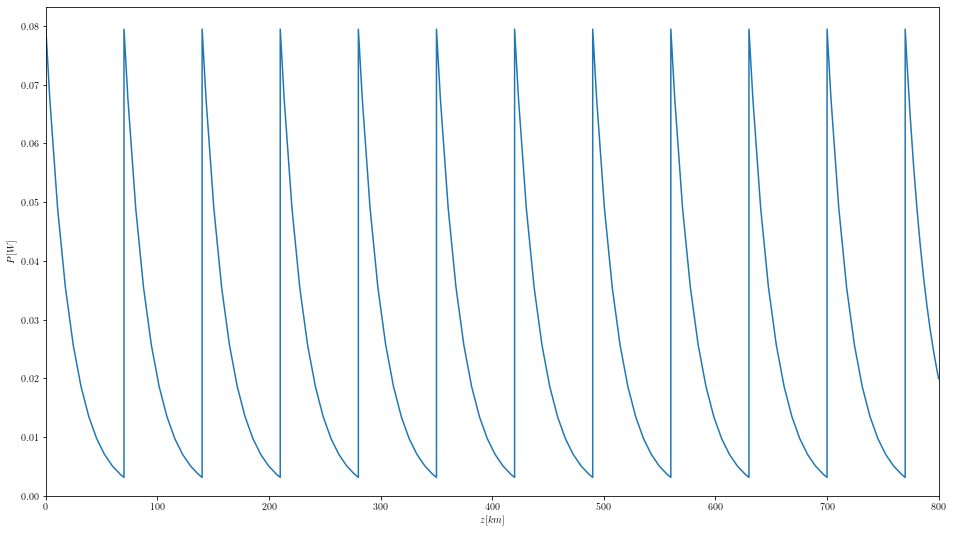

In [5]:
fig1, ax1 = plt.subplots(1, figsize=figure_size)

ax1.plot(xvals_full_distance, power_full_distance)
ax1.set_xlim(np.amin(xvals_full_distance), np.amax(xvals_full_distance))
ax1.set_ylim(bottom=0)
ax1.set_ylabel('$P[W]$')
ax1.set_xlabel('$z[km]$')

(0, 3.5356617094972154e-23)

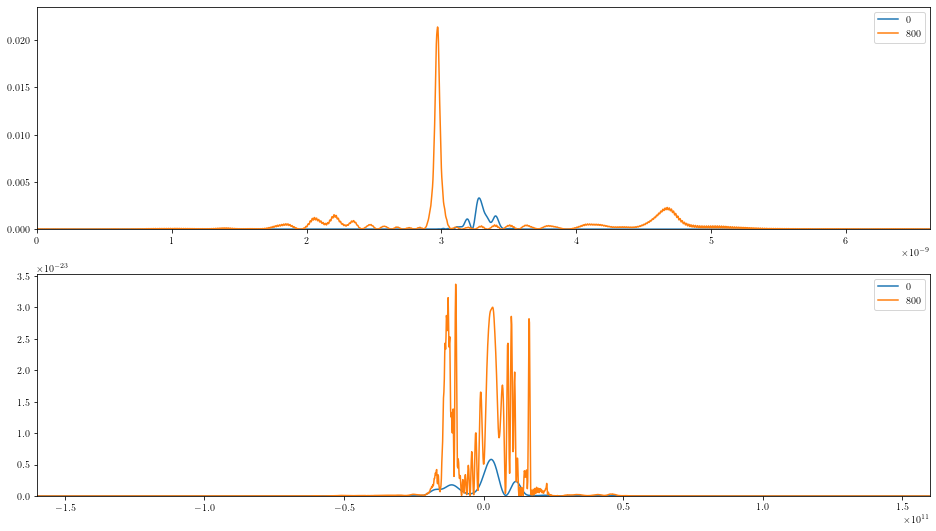

In [6]:
fig2, ax2 = plt.subplots(2, figsize=figure_size)
colors = cycle(list(mcolors.TABLEAU_COLORS))
ymax = 0
xvals = np.arange(send.size)*t_sample
xmin = np.amin(xvals)
xmax = np.amax(xvals)
ax2[0].set_xlim(xmin, xmax)

freq = np.fft.fftshift(np.fft.fftfreq(len(send),t_sample))
freqmin = np.amin(freq)
freqmax = np.amax(freq)
ax2[1].set_xlim(freqmin, freqmax)

for key, value in signals.items():
    if key in ['0', '800']:
        col=next(colors)
        ymax_new = np.amax(np.square(np.abs(value)))
        ax2[0].plot(xvals, np.square(np.abs(value)), label=key, color=col)
        ymin_is, ymax_is = ax2[0].get_ylim()
        if ymax < ymax_new:
            ymax = ymax_new
        ax2[0].set_ylim(0, ymax * 1.1)
        ax2[1].plot(freq, np.fft.fftshift(np.square(abs(t_sample*np.fft.fft(value)/np.sqrt(2*np.pi)))), label=key, color=col)
    
ax2[0].legend()
ax2[1].legend()
ax2[1].set_ylim(bottom=0)

In [7]:
next_input2 = amplifier(send, P_in, n_up, n_symbol)
signals2 = {'0': next_input2}
alpha2 = 0.0

for segment in range(int(full_distance / z_length)):
    segment_output2 = splitstepfourier(next_input2, t_sample, dz, nz, alpha2, beta2, gamma)
    signals2[f'{segment*z_length}'] = segment_output2
    
    if DEBUG:
        print(f"Segment {segment+1} power values: {segment_power}")
    if DEBUG_PLOT:
        plt.plot(np.real(segment_output2), label="Real")
        plt.plot(np.imag(segment_output2), label="Imag")
        plt.legend()
        plt.show()

    next_input2 = amplifier(segment_output2, P_in, n_up, n_symbol)

if full_distance % z_length != 0:
    rest_z_length = full_distance % z_length
    rest_dz = rest_z_length / nz
    rest_output2 = splitstepfourier(next_input2, t_sample, rest_dz, nz, alpha2, beta2, gamma)
    signals2[f'{full_distance}'] = rest_output2
 
    if DEBUG:
        print(f"last Segment ({rest_z_length} km) power values: {rest_power}")
    if DEBUG_PLOT:
        plt.plot(np.real(rest_output2), label="Real")
        plt.plot(np.imag(rest_output2), label="Imag")
        plt.legend()
        plt.show()

(0, 1.140167479911598e-22)

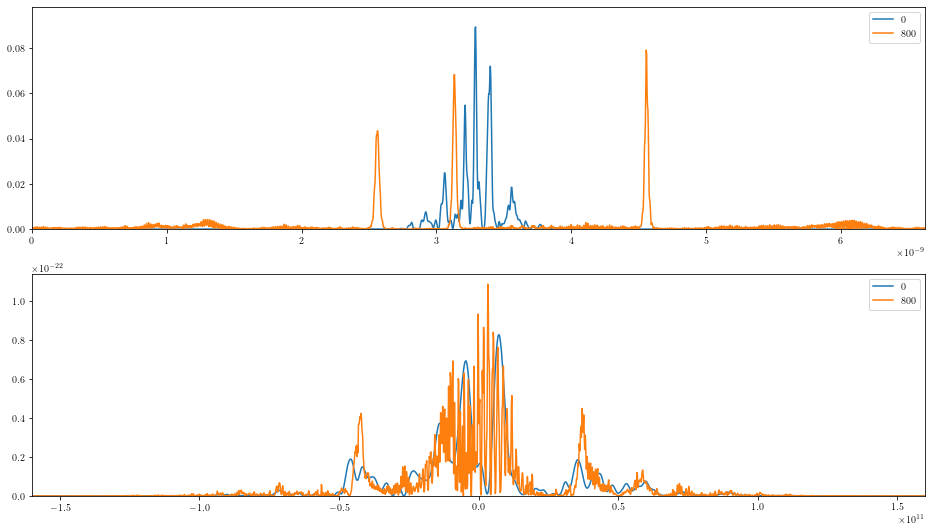

In [8]:
fig3, ax3 = plt.subplots(2, figsize=figure_size)
colors = cycle(list(mcolors.TABLEAU_COLORS))
ymax = 0
xvals = np.arange(send.size)*t_sample
xmin = np.amin(xvals)
xmax = np.amax(xvals)
ax3[0].set_xlim(xmin, xmax)

freq = np.fft.fftshift(np.fft.fftfreq(len(send),t_sample))
freqmin = np.amin(freq)
freqmax = np.amax(freq)
ax3[1].set_xlim(freqmin, freqmax)

for key, value in signals2.items():
    if key in ['0', '800']:
        col=next(colors)
        ymax_new = np.amax(np.square(np.abs(value)))
        ax3[0].plot(xvals, np.square(np.abs(value)), label=key, color=col)
        ymin_is, ymax_is = ax2[0].get_ylim()
        if ymax < ymax_new:
            ymax = ymax_new
        ax3[0].set_ylim(0, ymax * 1.1)
        ax3[1].plot(freq, np.fft.fftshift(np.square(abs(t_sample*np.fft.fft(value)/np.sqrt(2*np.pi)))), label=key, color=col)
    
ax3[0].legend()
ax3[1].legend()
ax3[1].set_ylim(bottom=0)

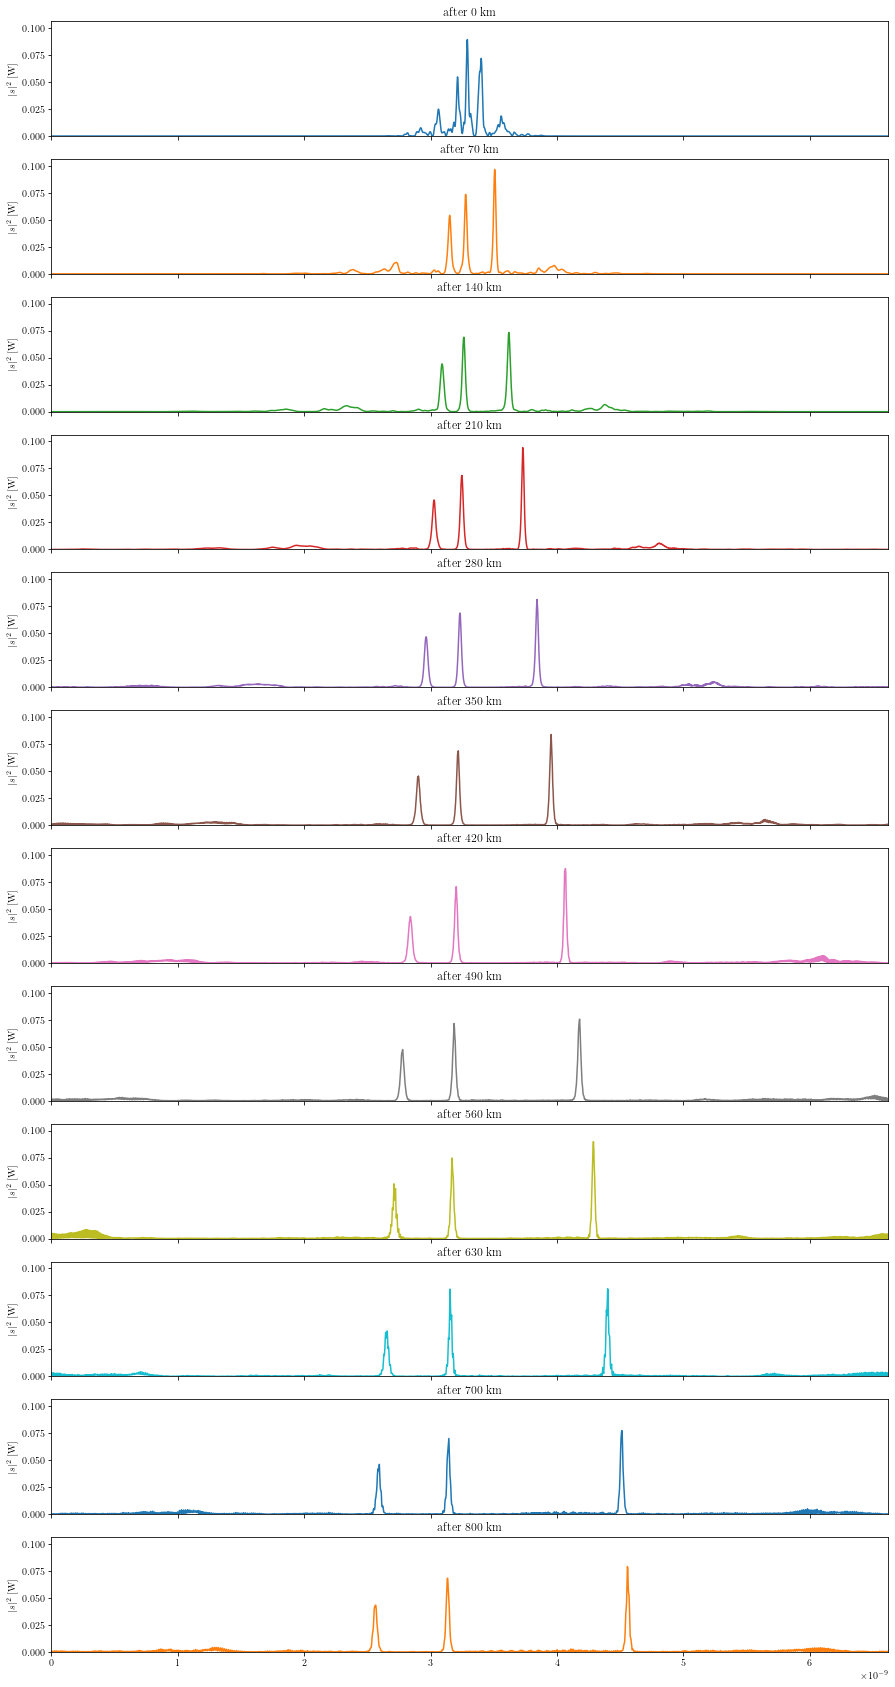

In [9]:
fig4, ax4 = plt.subplots(len(signals), figsize=(15,30), sharex=True)
colors = cycle(list(mcolors.TABLEAU_COLORS))
xvals = np.arange(send.size)*t_sample
xmin = np.amin(xvals)
xmax = np.amax(xvals)
ax4[0].set_xlim(xmin, xmax)
counter = 0

ymax = np.amax([np.square(np.abs(val)) for val in signals2.values()])

for key, val in signals2.items():
    ax4[counter].plot(xvals, np.square(np.abs(val)), label=key, color=next(colors))
    ax4[counter].set_ylim(0,ymax*1.1)
    ax4[counter].set_title(f"after {key} km")
    ax4[counter].set_ylabel("$|s|^2$ [W]")
    counter += 1

In [10]:
output_fname = "long_distance"
output_path = "../../../bachelorarbeit-ausarbeitung/figures/plots/"

tikzplotlib.save(f'{output_path}{output_fname}_power_level.tex', figure=fig1, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)
tikzplotlib.save(f'{output_path}{output_fname}_io.tex', figure=fig2, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)
tikzplotlib.save(f'{output_path}{output_fname}_io_noalpha.tex', figure=fig3, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)
tikzplotlib.save(f'{output_path}{output_fname}_progress_noalpha.tex', figure=fig4, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)

fig1.savefig(f"{output_path}{output_fname}_power_level.pdf", bbox_inches='tight')
fig2.savefig(f"{output_path}{output_fname}_io.pdf", bbox_inches='tight')
fig3.savefig(f"{output_path}{output_fname}_io_noalpha.pdf", bbox_inches='tight')
fig4.savefig(f"{output_path}{output_fname}_progress_noalpha.pdf", bbox_inches='tight')